In [1]:
%matplotlib inline
import random
import torch
from d2l import torch as d2l

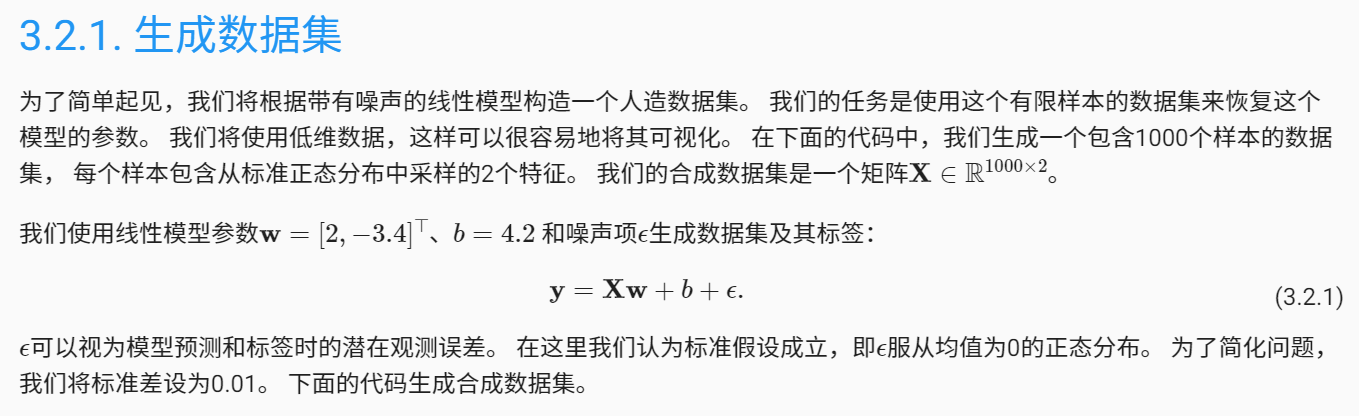

In [4]:
def synthetic_data(w,b,num_examples):#@save
    """生成y=Xw+b+噪声"""
    X = torch.normal(0,1,(num_examples,len(w)))#生成特征值
    y = torch.matmul(X,w)+b
    y += torch.normal(0,0.01,y.shape)
    return X,y.reshape((-1,1))


In [5]:
true_w = torch.tensor([2,-3.4])
true_b = 4.2
features,labels = synthetic_data(true_w,true_b,1000)

In [6]:
print('features:', features[0],'\nlabel:', labels[0])

features: tensor([ 1.2369, -0.7623]) 
label: tensor([9.2775])


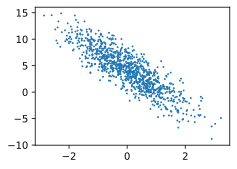

In [10]:
d2l.set_figsize()
d2l.plt.scatter(features[:, 1].detach().numpy(), labels.detach().numpy(), 1);

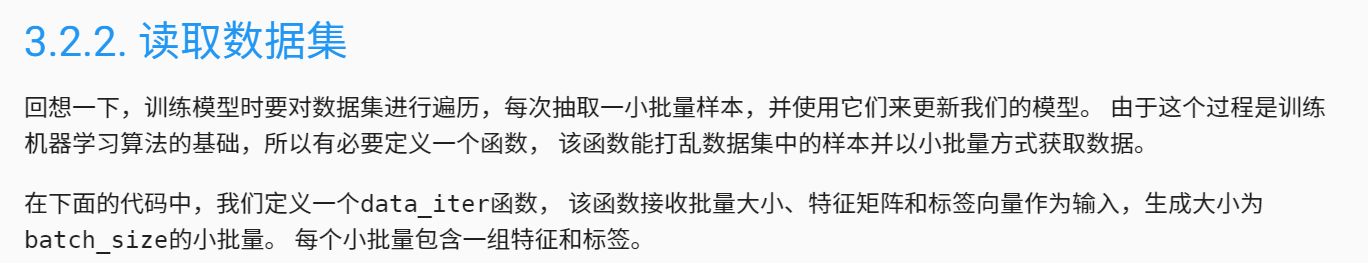

In [11]:
def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    # 这些样本是随机读取的，没有特定的顺序
    random.shuffle(indices)
    for i in range(0, num_examples, batch_size):
        batch_indices = torch.tensor(indices[i: min(i + batch_size, num_examples)])
        yield features[batch_indices], labels[batch_indices]

In [12]:
batch_size = 10

for X, y in data_iter(batch_size, features, labels):
    print(X, '\n', y)
    break

tensor([[ 0.5864, -1.4269],
        [-0.7241,  0.4263],
        [ 0.0926,  0.1851],
        [-0.2871, -0.0385],
        [-0.0123,  0.7839],
        [-1.5719, -0.8600],
        [ 0.0684,  0.1369],
        [ 1.0830,  0.4507],
        [ 0.9678, -0.6280],
        [-0.6656, -0.5077]]) 
 tensor([[10.2338],
        [ 1.3101],
        [ 3.7549],
        [ 3.7680],
        [ 1.5059],
        [ 3.9767],
        [ 3.8869],
        [ 4.8482],
        [ 8.2798],
        [ 4.5862]])


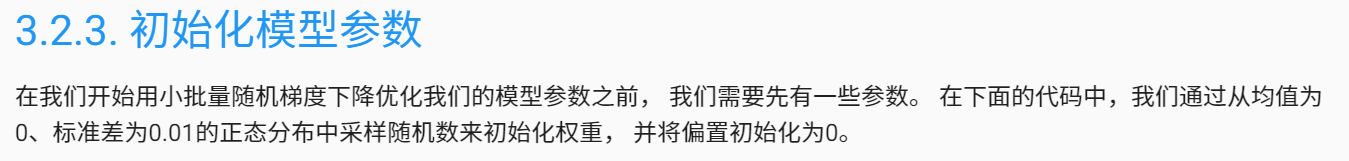

In [13]:
w = torch.normal(0, 0.01, size=(2,1), requires_grad=True)
b = torch.zeros(1, requires_grad=True)

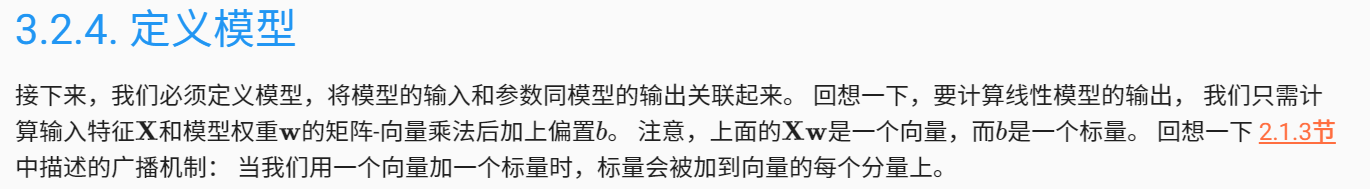

In [14]:
def linreg(X, w, b):  #@save
    """线性回归模型"""
    return torch.matmul(X, w) + b

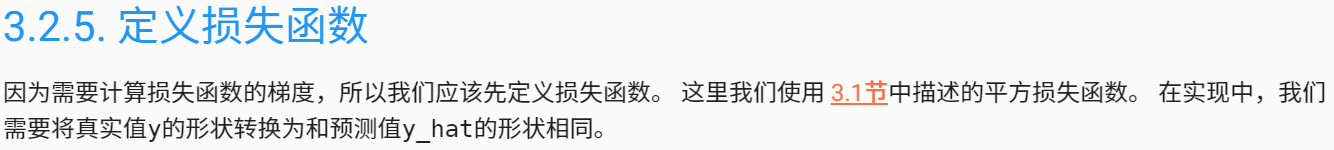

In [15]:
def squared_loss(y_hat, y):  #@save
    """均方损失"""
    return (y_hat - y.reshape(y_hat.shape)) ** 2 / 2

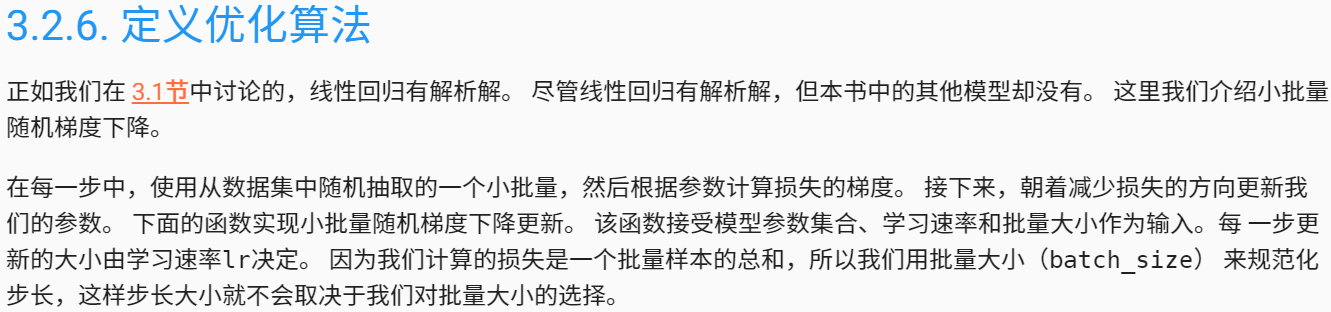

In [16]:
def sgd(params, lr, batch_size):  #@save
    """小批量随机梯度下降"""
    with torch.no_grad():
        for param in params:
            param -= lr * param.grad / batch_size
            param.grad.zero_()

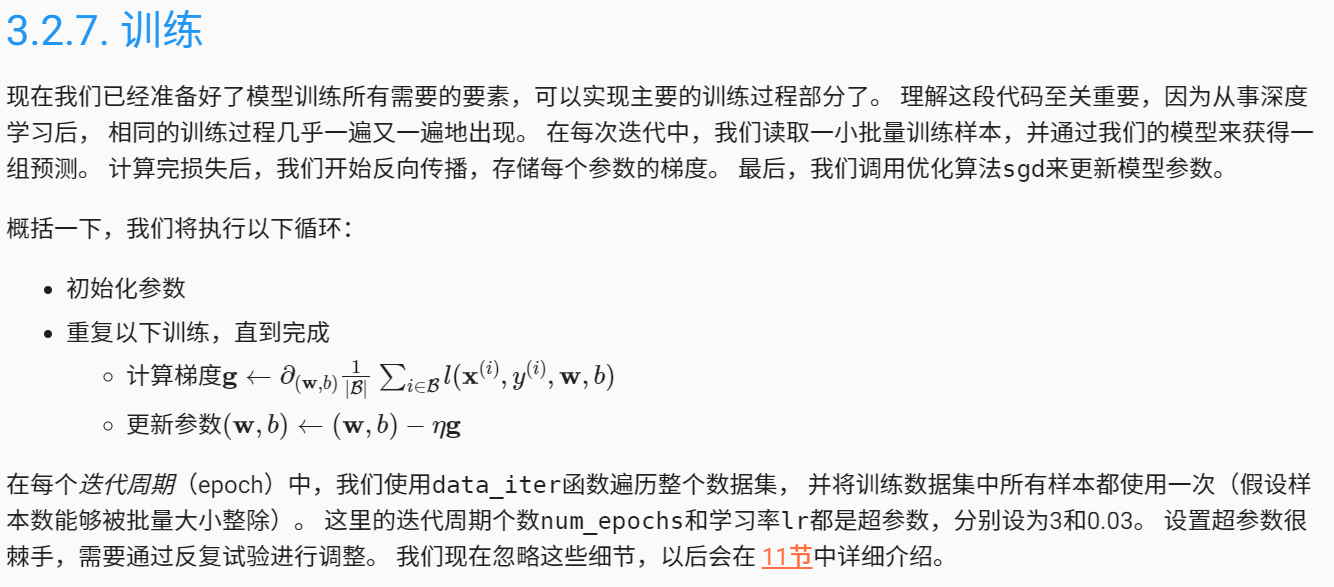

In [17]:
lr = 0.03
num_epochs = 3
net = linreg
loss = squared_loss

for epoch in range(num_epochs):
    for X, y in data_iter(batch_size, features, labels):
        l = loss(net(X, w, b), y)  # X和y的小批量损失
        # 因为l形状是(batch_size,1)，而不是一个标量。l中的所有元素被加到一起，
        # 并以此计算关于[w,b]的梯度
        l.sum().backward()
        sgd([w, b], lr, batch_size)  # 使用参数的梯度更新参数
    with torch.no_grad():
        train_l = loss(net(features, w, b), labels)
        print(f'epoch {epoch + 1}, loss {float(train_l.mean()):f}')

epoch 1, loss 0.046351
epoch 2, loss 0.000182
epoch 3, loss 0.000051


In [18]:
print(f'w的估计误差: {true_w - w.reshape(true_w.shape)}')
print(f'b的估计误差: {true_b - b}')

w的估计误差: tensor([0.0001, 0.0003], grad_fn=<SubBackward0>)
b的估计误差: tensor([0.0008], grad_fn=<RsubBackward1>)


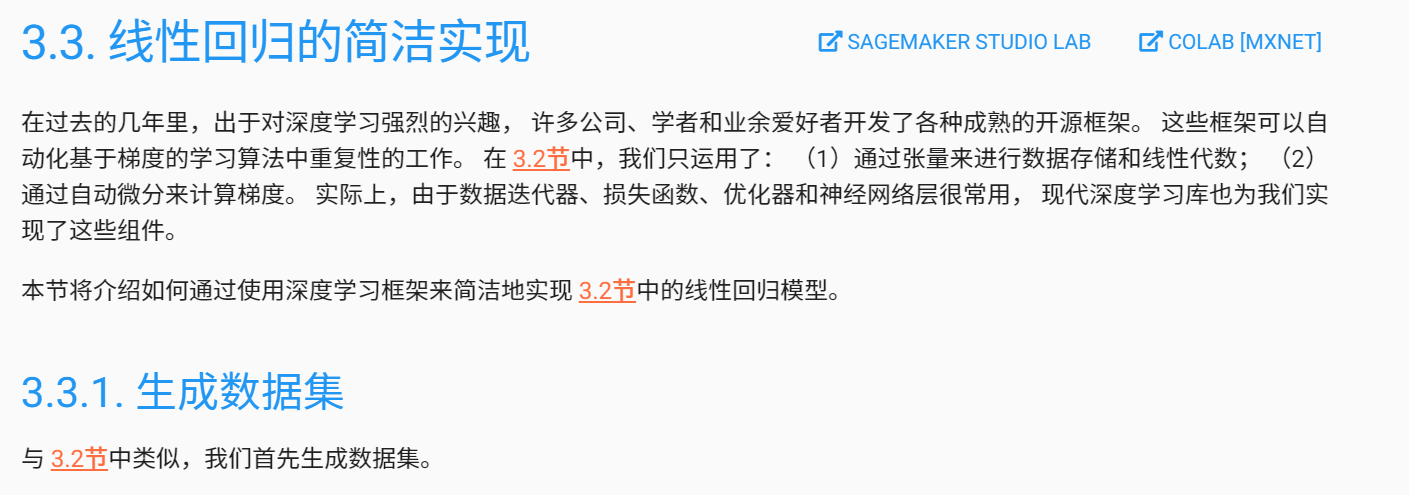

In [19]:
import numpy as np
import torch
from torch.utils import data
from d2l import torch as d2l

true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = d2l.synthetic_data(true_w, true_b, 1000)

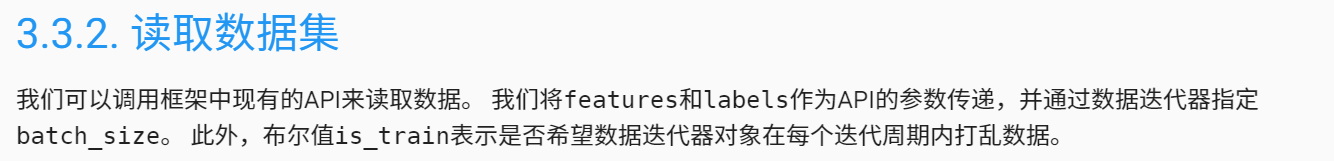

In [22]:
def load_array(data_arrays, batch_size, is_train=True):  #@save
    """构造一个PyTorch数据迭代器"""
    dataset = data.TensorDataset(*data_arrays)
    return data.DataLoader(dataset, batch_size, shuffle=is_train)

In [23]:
batch_size = 10
data_iter = load_array((features, labels), batch_size)
next(iter(data_iter))

[tensor([[ 0.0797,  0.3983],
         [ 0.3350,  0.4833],
         [ 1.9651, -1.2854],
         [-0.6517, -0.4510],
         [ 0.0388, -0.4536],
         [-0.4678,  0.0838],
         [ 0.1322, -0.6650],
         [-0.4041, -0.0104],
         [ 1.4010,  2.8808],
         [ 0.0981, -0.4934]]),
 tensor([[ 3.0161],
         [ 3.2257],
         [12.5075],
         [ 4.4209],
         [ 5.8290],
         [ 2.9684],
         [ 6.7282],
         [ 3.4277],
         [-2.8056],
         [ 6.0792]])]

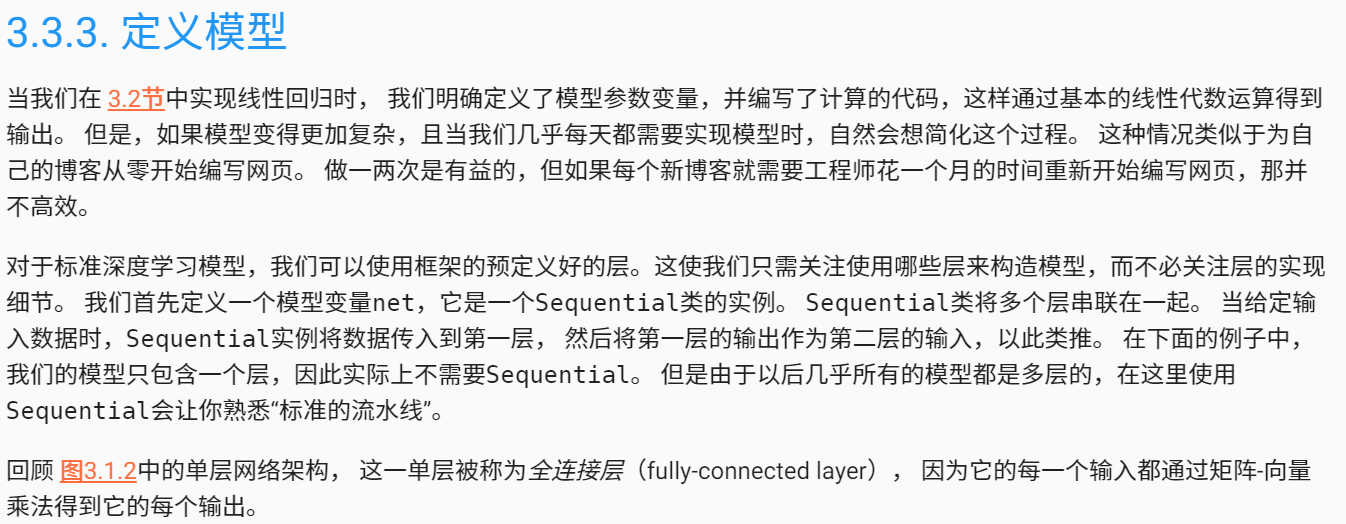

In [24]:
# nn是神经网络的缩写
from torch import nn

net = nn.Sequential(nn.Linear(2, 1))

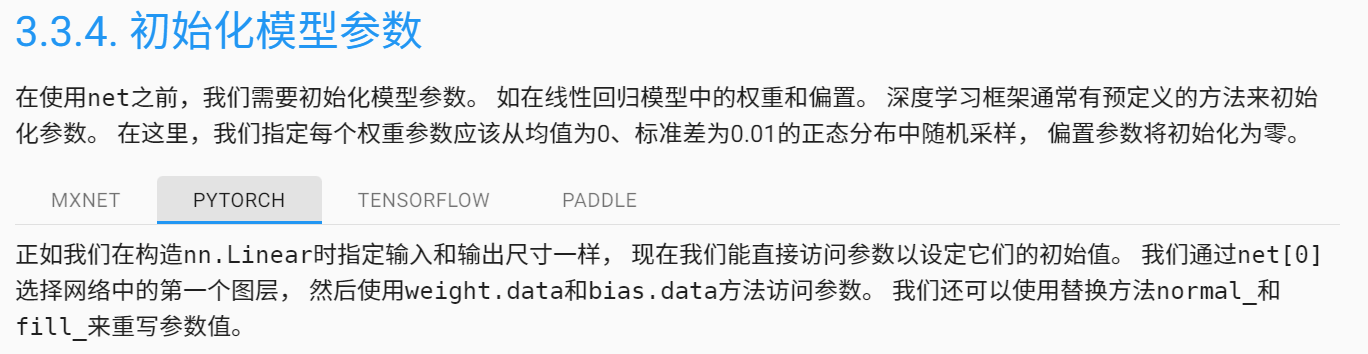

In [25]:
net[0].weight.data.normal_(0, 0.01)
net[0].bias.data.fill_(0)

tensor([0.])

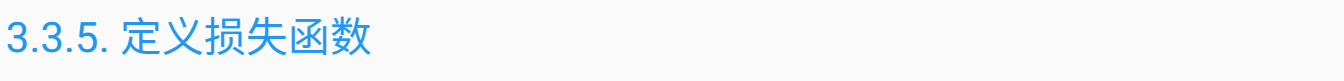
计算均方误差使用的是MSELoss类，也称为平方
范数。 默认情况下，它返回所有样本损失的平均值。

In [26]:
loss = nn.MSELoss()

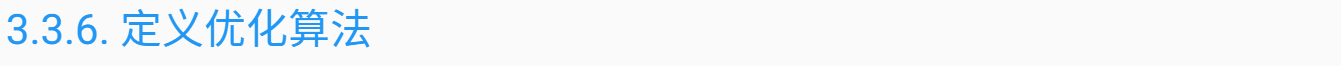
小批量随机梯度下降算法是一种优化神经网络的标准工具， PyTorch在optim模块中实现了该算法的许多变种。 当我们实例化一个SGD实例时，我们要指定优化的参数 （可通过net.parameters()从我们的模型中获得）以及优化算法所需的超参数字典。 小批量随机梯度下降只需要设置lr值，这里设置为0.03。

In [27]:
trainer = torch.optim.SGD(net.parameters(), lr=0.03)

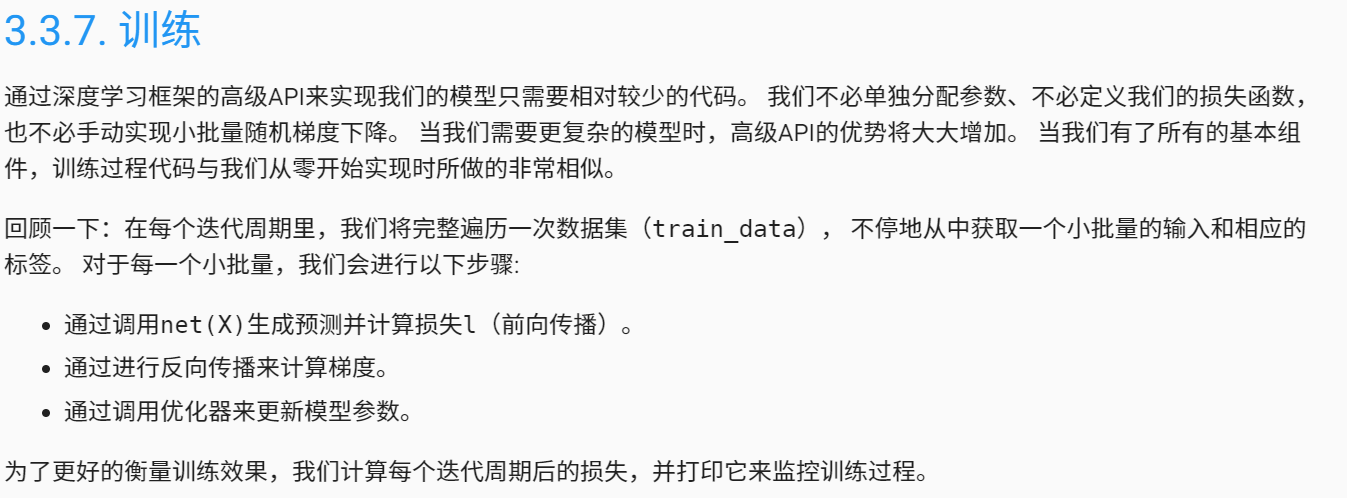

In [30]:
num_epochs = 30
for epoch in range(num_epochs):
    for X, y in data_iter:
        l = loss(net(X) ,y)
        trainer.zero_grad()
        l.backward()
        trainer.step()
    l = loss(net(features), labels)
    print(f'epoch {epoch + 1}, loss {l:f}')

epoch 1, loss 0.000102
epoch 2, loss 0.000101
epoch 3, loss 0.000102
epoch 4, loss 0.000101
epoch 5, loss 0.000101
epoch 6, loss 0.000104
epoch 7, loss 0.000102
epoch 8, loss 0.000102
epoch 9, loss 0.000101
epoch 10, loss 0.000101
epoch 11, loss 0.000101
epoch 12, loss 0.000101
epoch 13, loss 0.000101
epoch 14, loss 0.000102
epoch 15, loss 0.000101
epoch 16, loss 0.000102
epoch 17, loss 0.000102
epoch 18, loss 0.000102
epoch 19, loss 0.000103
epoch 20, loss 0.000102
epoch 21, loss 0.000102
epoch 22, loss 0.000101
epoch 23, loss 0.000101
epoch 24, loss 0.000102
epoch 25, loss 0.000101
epoch 26, loss 0.000101
epoch 27, loss 0.000101
epoch 28, loss 0.000101
epoch 29, loss 0.000102
epoch 30, loss 0.000101


In [31]:
w = net[0].weight.data
print('w的估计误差：', true_w - w.reshape(true_w.shape))
b = net[0].bias.data
print('b的估计误差：', true_b - b)

w的估计误差： tensor([ 0.0003, -0.0001])
b的估计误差： tensor([0.0004])
